In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from src.dataset.coco import get_coco
import src.dataset.DatasetReader as DatasetReader
import matplotlib.pyplot as plt
import src.dataset.utils as utils
import time
import datetime
import os
import numpy as np

In [2]:
if torch.cuda.is_available():
    print("using cuda")
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("mps")
else:
    print("using cpu")
    device = torch.device("cpu")

using cuda
NVIDIA GeForce RTX 3050


In [3]:

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.ColorJitter(brightness = 0.5),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


In [6]:

dataset_coco = DatasetReader.COCODataset(annotation_file='datasets/coco/annotations/instances_train2017.json',
    image_dir= 'datasets/coco/train2017',
    target_classes=[s.lower() for s in utils.GLOBAL_CLASSES],
    transform=transform)


root_folder = 'datasets/imagenet/coco_80'
class_names = [s.lower().replace(' ', '_') for s in utils.GLOBAL_CLASSES]
dataset_imagenet = DatasetReader.CustomImageFolder(root_dir=root_folder, class_names=class_names, transform=transform)

dataset = torch.utils.data.ConcatDataset([dataset_coco, dataset_imagenet])

batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=15, prefetch_factor=4, persistent_workers=True)

model = models.mobilenet_v3_small(pretrained=True)
# model = models.mobilenet_v3_large(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 64)  
model = model.to(device)

print(len(dataset))
# print(dataset[90001][1])


672065


/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6301525..2.64].


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


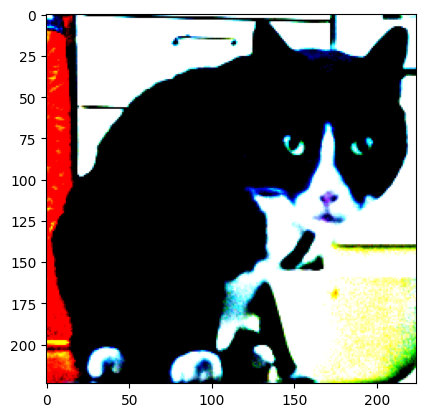

In [45]:

print(dataset[599000][0].shape)
print(dataset[0][0].shape)

plt.imshow(np.transpose(dataset[500][0], (1, 2, 0)))

In [243]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)

def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    start_datetime = datetime.datetime.now()
    os.mkdir(f'models/{start_datetime}')
    
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        for i, (images, labels) in enumerate(dataloader):

            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
        asdf = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(dataloader):.4f}, Time: {asdf:.4f}s")
        if np.mod(epoch, 5) == 0:
            torch.save(model.state_dict(), f"models/{start_datetime}/model_{epoch}epoha_coco_train_batch_size_{batch_size}.pth")

In [244]:
weights = torch.load("models/2025-02-10 19:54:17.749289/model_70epoha_coco_train_batch_size_256.pth")
model.load_state_dict(weights)
model.train
train_model(model, dataloader, criterion, optimizer, 100)

Epoch [1/100], Step [10/2626], Loss: 0.4147
Epoch [1/100], Step [20/2626], Loss: 0.3680
Epoch [1/100], Step [30/2626], Loss: 0.4362
Epoch [1/100], Step [40/2626], Loss: 0.4408
Epoch [1/100], Step [50/2626], Loss: 0.4071
Epoch [1/100], Step [60/2626], Loss: 0.4705
Epoch [1/100], Step [70/2626], Loss: 0.4049
Epoch [1/100], Step [80/2626], Loss: 0.4226
Epoch [1/100], Step [90/2626], Loss: 0.4363
Epoch [1/100], Step [100/2626], Loss: 0.4819
Epoch [1/100], Step [110/2626], Loss: 0.4077
Epoch [1/100], Step [120/2626], Loss: 0.2635
Epoch [1/100], Step [130/2626], Loss: 0.4531
Epoch [1/100], Step [140/2626], Loss: 0.3032
Epoch [1/100], Step [150/2626], Loss: 0.3835
Epoch [1/100], Step [160/2626], Loss: 0.3262
Epoch [1/100], Step [170/2626], Loss: 0.5167
Epoch [1/100], Step [180/2626], Loss: 0.4160
Epoch [1/100], Step [190/2626], Loss: 0.5114
Epoch [1/100], Step [200/2626], Loss: 0.3304
Epoch [1/100], Step [210/2626], Loss: 0.3333
Epoch [1/100], Step [220/2626], Loss: 0.3946
Epoch [1/100], Step

In [246]:
start_datetime = datetime.datetime.now()
torch.save(model.state_dict(), f"models/2025-02-11 12:41:38.815585/model_{100}epoha_coco_train_batch_size_{batch_size}.pth")

# Evaluation
- treba da se stavi da koristi validacioni dataaset

In [46]:
model.eval()

weights = torch.load("models/2025-02-11 12:41:38.815585/model_100epoha_coco_train_batch_size_256.pth")

model.load_state_dict(weights)

totalPost = 0
accuracyPost = 0

dataset = DatasetReader.COCODataset(annotation_file='datasets/coco/annotations/instances_val2017.json',
    image_dir= 'datasets/coco/val2017',
    target_classes=[s.lower() for s in utils.GLOBAL_CLASSES],
    transform=transform)

# batch_size = 256
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=11, prefetch_factor=4, persistent_workers=True)


for i in range(0, len(dataset)):
    totalPost += 1
    image, label = dataset[i]
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    # print(f"Predicted: {predicted.item()}, Actual: {label.item()}")
    if(i % 1000 == 0):
        print(f"Slika: {i}")
    if predicted.item() == label.item():
        accuracyPost += 1
    

print(f"Accuracy: {accuracyPost/totalPost}")

Slika: 0
Slika: 1000
Slika: 2000
Slika: 3000
Slika: 4000
Slika: 5000
Slika: 6000
Slika: 7000
Slika: 8000
Slika: 9000
Slika: 10000
Slika: 11000
Slika: 12000
Slika: 13000
Slika: 14000
Slika: 15000
Slika: 16000
Slika: 17000
Slika: 18000
Slika: 19000
Slika: 20000
Slika: 21000
Slika: 22000
Slika: 23000
Accuracy: 0.7525061840906132


In [ ]:
# ovo save-uje model
# torch.save(model.state_dict(), "model_50epoch_coco_val_batch_size_384_acc_79.2.pth")

In [ ]:
# model2 = models.mobilenet_v3_small(pretrained=True)
# model2.classifier[3] = nn.Linear(model2.classifier[3].in_features, 64)  
# model2 = model2.to(device)


# model2.train()

# for param in model2.features.parameters():

#     param.requires_grad = False



# for param in model2.classifier.parameters():

#     param.requires_grad = True




In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model2.parameters(), lr=0.00002)

# train_model(model2, dataloader, criterion, optimizer, num_epochs=50)

In [53]:
import requests
from PIL import Image


# model = models.mobilenet_v3_small(pretrained=True)
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, 64)  
# model = model.to(device)

# weights = torch.load("models/2025-02-08 20:17:41.338644/model_50epoha_coco_train_batch_size_256.pth")

# model.load_state_dict(weights)

model.eval()

# sample_image_url = (
#     "https://qaihub-public-assets.s3.us-west-2.amazonaws.com/apidoc/input_image1.jpg"
# )
# response = requests.get(sample_image_url, stream=True)
# response.raw.decode_content = True
# image = Image.open(response.raw).resize((224, 224))

# imageT = transform(image)
# imageT = imageT.to(device)
# imageT = torch.unsqueeze(imageT, 0)

# print(imageT.shape)

# cupOutput = model(imageT)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [54]:
from src.dataset.utils import GLOBAL_CLASSES
from src.utils.helper import print_probablities_from_output

#print_probablities_from_output(cupOutput, GLOBAL_CLASSES, 10, 'V3_Small_trained', 'Cup')


In [172]:
idx = 0

In [109]:
from torchvision import datasets
def compute_mean_std(folderpath):
    #loader = DataLoader(dataset, batch_size = batch_size, shuffle = False, num_workers=4)

    dataset = datasets.ImageFolder(
        root = "/home/centar15-desktop1/Desktop/example_data/images-20250210T115939Z-001/",
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
            ]))
    loader = DataLoader(dataset, batch_size=1, shuffle=False)


    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0
    for images, ____ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples,3,-1)
        mean+=images.mean(dim=[0,2])
        std+=images.std(dim=[0,2])
        total_samples +=batch_samples

    mean/=100
    std/= 100

    return mean, std

print(compute_mean_std("/home/centar15-desktop1/Desktop/example_data/images-20250210T115939Z-001/images/"))

(tensor([0.4435, 0.3968, 0.3221]), tensor([0.2266, 0.2126, 0.2013]))


In [1]:
import matplotlib.pyplot as plt
import skimage as ski



modelPretrained = models.mobilenet_v3_small(pretrained=True)
# model = models.mobilenet_v3_large(pretrained=True)
modelPretrained = modelPretrained.to(device)

folderpath = "/home/centar15-desktop1/Desktop/example_data/images-20250210T115939Z-001/images/"




transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4435, 0.3968, 0.3221], std=[0.2266, 0.2126, 0.2013]),  
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0).to(device))
])

image = Image.open(folderpath + f"{idx}.jpg")

if image.mode == 'RGBA':
    # Convert the image to RGB (remove alpha channel)
    image = image.convert('RGB')

# image = ski.io.imread(folderpath + f"{idx}.jpg")

# print(image.shape)

# image = image[:,:, :3]
# image2 = np.transpose(image, (2, 0, 1))

# print(image.shape)

plt.imshow(image)
plt.show()

print_probablities_from_output(model(transform2(image)), GLOBAL_CLASSES, 10, 'V3_Small_trained')

idx = idx + 1
 

NameError: name 'models' is not defined

In [48]:
import pandas as pd
import os
from PIL import Image

model.eval()
totalPost = 0
accuracyPost = 0

annot = pd.read_csv('../data/njihov_test/key.csv')
image_folder = '../data/njihov_test/images'

for index, row in annot.iterrows():
    image_path = os.path.join(image_folder, row['file_name'])
    print(image_path)
    if os.path.exists(image_path):
        label = row['class_index']
        image = Image.open(image_path).convert("RGB")

        totalPost += 1
        image = transform(image).unsqueeze(0)
        image = image.to(device)

        label = torch.tensor([label]).to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Predicted: {predicted.item()}, Actual: {label.item()}")
        if(index % 1000 == 0):
            print(f"Slika: {index}")

        if predicted.item() == label.item():
            accuracyPost += 1
    else:
        print(f"Image {row['file_name']} not found")

print(f"Accuracy: {accuracyPost/totalPost}")

../data/njihov_test/images/airplane_indoor_backlit_00.png
Predicted: 3, Actual: 3
Slika: 0
../data/njihov_test/images/airplane_indoor_backlit_01.png
Predicted: 3, Actual: 3
../data/njihov_test/images/airplane_outdoor_normal_light_01.png
Predicted: 3, Actual: 3
../data/njihov_test/images/airplane_outdoor_normal_light_02.png
Predicted: 3, Actual: 3
../data/njihov_test/images/apple_indoor_backlit_00.png
Predicted: 36, Actual: 36
../data/njihov_test/images/apple_indoor_low_light_01.png
Predicted: 36, Actual: 36
../data/njihov_test/images/apple_indoor_low_light_02.png
Predicted: 36, Actual: 36
../data/njihov_test/images/apple_synthetic_01.png
Predicted: 35, Actual: 36
../data/njihov_test/images/apple_synthetic_02.png
Predicted: 36, Actual: 36
../data/njihov_test/images/ball_indoor_normal_light_01.jpg
Predicted: 1, Actual: 26
../data/njihov_test/images/ball_indoor_normal_light_02.jpg
Predicted: 46, Actual: 26
../data/njihov_test/images/banana_indoor_backlit_00.png
Predicted: 35, Actual: 35
.

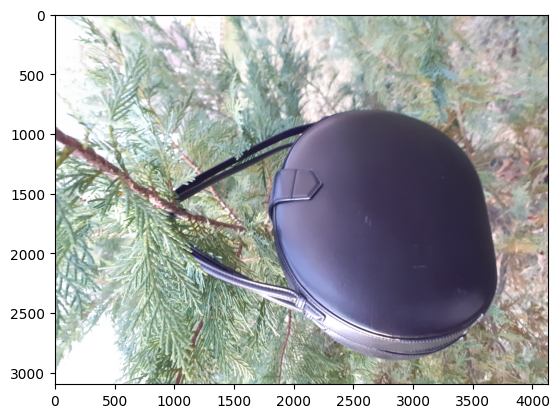

Top-10 predictions for V3_Small_Pretrained on :
909 b'wok'                42.1%
618 b'ladle'              11.3%
807 b'solar dish'          5.4%
302 b'ground beetle'       4.6%
5 b'electric ray'        4.6%
567 b'frying pan'          4.3%
314 b'cockroach'           3.7%
988 b'acorn'               1.8%
313 b'walking stick'       1.7%
469 b'caldron'             1.5%


In [164]:
modelPretrained = models.mobilenet_v3_small(pretrained=True)
# model = models.mobilenet_v3_large(pretrained=True)
modelPretrained = modelPretrained.to(device)

modelPretrained.eval()

folderpath = "/home/centar15-desktop1/Desktop/example_data/images-20250210T115939Z-001/images/"

from src.utils.helper import get_imagenet_categories

klas = get_imagenet_categories()


transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[0.4435, 0.3968, 0.3221], std=[0.2266, 0.2126, 0.2013]),  
    transforms.Lambda(lambda x: x.unsqueeze(0).to(device))
])

image = Image.open(folderpath + f"{idx}.jpg")

if image.mode == 'RGBA':
    # Convert the image to RGB (remove alpha channel)
    image = image.convert('RGB')

# image = ski.io.imread(folderpath + f"{idx}.jpg")

# print(image.shape)

# image = image[:,:, :3]
# image2 = np.transpose(image, (2, 0, 1))

# print(image.shape)



plt.imshow(image)
plt.show()

print_probablities_from_output(modelPretrained(transform2(image)), klas, 10, 'V3_Small_Pretrained')

idx = idx + 1

In [170]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float16)


/home/centar15-desktop1/LPCV_2025_T1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-12 16:21:28.862770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 16:21:28.870132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739373688.876287  518828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739373688.878258  518828 cuda_b

In [175]:
model = model.to(device)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [176]:
totalPost = 0
accuracyPost = 0

annot = pd.read_csv('../data/njihov_test/key.csv')
image_folder = '../data/njihov_test/images'

for index, row in annot.iterrows():
    image_path = os.path.join(image_folder, row['file_name'])
    print(image_path)
    if os.path.exists(image_path):
        label = row['class_index']
        image = Image.open(image_path).convert("RGB")

        totalPost += 1
        image = transform(image).unsqueeze(0)
        image = image.to(device)

        label = torch.tensor([label]).to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Predicted: {predicted.item()}, Actual: {label.item()}")
        if(index % 1000 == 0):
            print(f"Slika: {index}")

        if predicted.item() == label.item():
            accuracyPost += 1
    else:
        print(f"Image {row['file_name']} not found")

print(f"Accuracy: {accuracyPost/totalPost}")

../data/njihov_test/images/airplane_indoor_backlit_00.png


TypeError: max() received an invalid combination of arguments - got (ImageClassifierOutput, int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)
